# Econometric Models
This notebook contains the following statistical models:
- AR
- ARIMA
- SARIMA

## **Prepare Environment**

### Imports

In [87]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# autoarima
import pmdarima as pm

# Others
from IPython.display import Image
import warnings
import pprint
import datetime
import itertools
import os

# custom functions
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path

from utils import (
    path_to_work,
    plot_box_plot,
    save_image,
    save_dataframe,
    test_stationary,
    show_result_model,
)

### Prepare Principal Directory

In [88]:
path_to_work('notebooks')

'Current working directory: /Users/bruno.campos/projects/forecast-of-time-series-with-stock-data'

### Set Config

In [128]:
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload
%autoreload 2
%rehashx # clear cache

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)


# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

plt.style.use('fivethirtyeight')

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [90]:
%%time
df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv', encoding='utf8', delimiter=',', parse_dates=True, index_col=0, verbose=True)
df_vale3.head()

Tokenization took: 1.74 ms
Type conversion took: 2.03 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 8.64 ms, sys: 3.63 ms, total: 12.3 ms
Wall time: 11.7 ms


,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.00,1.00,41.83,1.00,-0.60,-0.46,0.49,0.98,0.42
2010-07-13,40.07,1.04,41.91,1.00,0.07,-0.53,-0.39,0.56,1.05
2010-07-14,40.08,1.03,41.98,1.00,0.01,0.08,-0.52,-0.38,0.57
2010-07-15,39.76,1.04,42.05,1.00,-0.32,-0.31,-0.24,-0.84,-0.70
2010-07-16,38.88,1.03,42.12,1.00,-0.88,-1.20,-1.19,-1.12,-1.72


## Split Data

In [91]:
size_train = 2132
size_test = 313
print(size_train)
print(size_test)

df_train = df_vale3['preco'].iloc[:size_train]
df_test = df_vale3['preco'].iloc[size_train:]
df_train.tail()

2132
313


data
2019-02-15   45.88
2019-02-18   45.25
2019-02-19   45.49
2019-02-20   45.80
2019-02-21   45.38
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Treinamento = 2132')

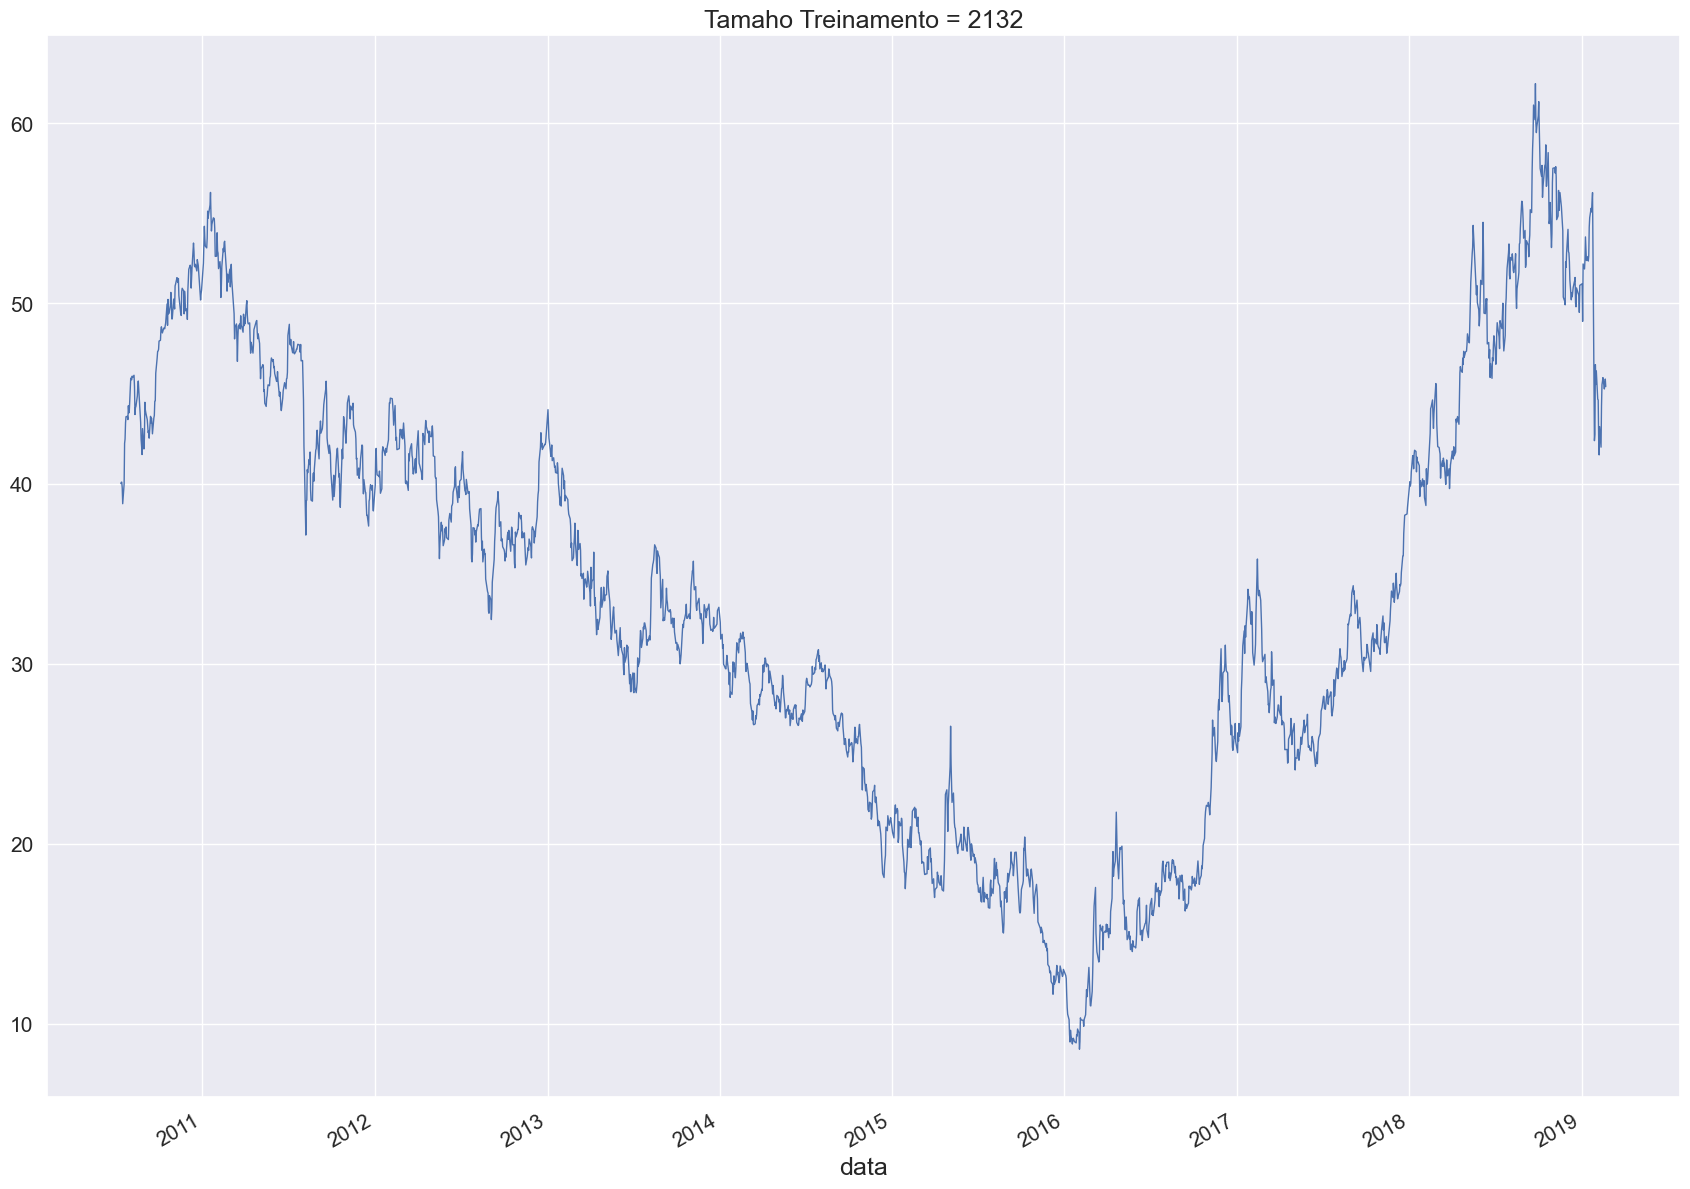

In [92]:
df_train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Treinamento = {len(df_train)}')

Text(0.5, 1.0, 'Tamaho Teste = 313')

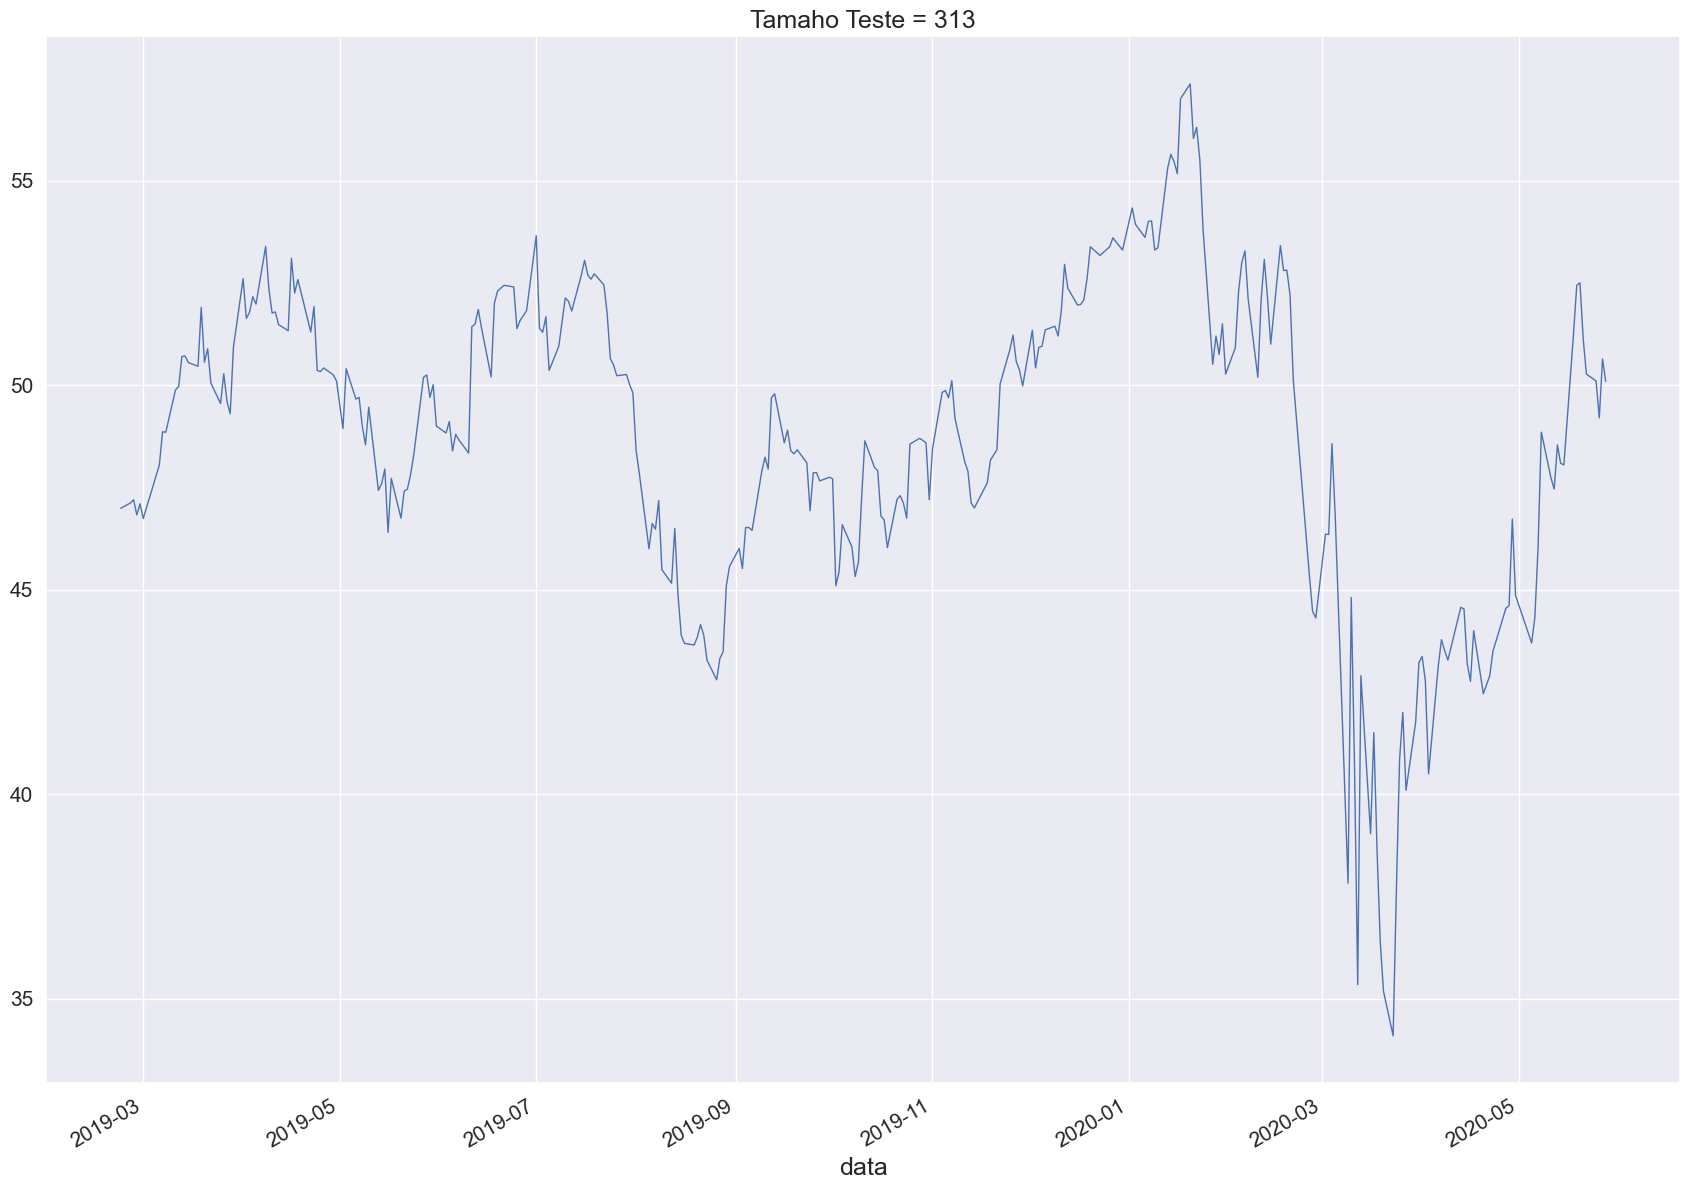

In [93]:
df_test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Teste = {len(df_test)}')

### Handle Index

In [94]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)

In [95]:
df_test.index

DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', length=313, freq=None)

In [96]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=2132, step=1)

In [97]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=313, step=1)

In [98]:
df_train.index = pd.RangeIndex(start=0, stop=len(df_train), step=1)
df_train.index

RangeIndex(start=0, stop=2132, step=1)

In [99]:
df_test.index = pd.RangeIndex(start=2132, stop=len(df_vale3), step=1)
df_test.index

RangeIndex(start=2132, stop=2445, step=1)

---

## **Evaluation**

In [100]:
dict_results = {}

### Find the Best Parameters

#### Grid Search

In [101]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0, 3)

# Generate all different combinations of p, q and q triplets
list_pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {list_pdq}')

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [102]:
def search_best_params_arima_model(df_train: pd.core.frame.DataFrame, pdq: list) -> list:
    best_model = 99999
    best_params = (0, 0, 0)
    param = ()

    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_params = param
        except:
            continue

    print(f'best ARIMA: {best_params} | AIC:{best_model}')
    return [best_params, best_model]

In [103]:
def search_best_params_sarima_model(df_train: pd.core.frame.DataFrame, trend, pdq):
    best_model = 99999
    best_param_seasonal = ()
    param = ()
    param_seasonal = ()

    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_param_seasonal = param_seasonal
        except:
            continue

    print(f'\n\nBest SARIMA: {pdq}x{param_seasonal}12 | AIC:{best_model}')
    return [best_param_seasonal, best_model]

---

## **Modeling**

### **Building Models**
#### Econometric Models

#### **AR**
- The time series (ST) is non-stationary.
- There is no trend (trend='n').
- There is no seasonality (seasonal=False) over the 30-day period.

In [104]:
ar_model = AutoReg(df_train,
                   lags=313,
                   trend='n',
                   seasonal=False,
                   period=len(df_test))
ar_fit = ar_model.fit()

In [105]:
# forecast
y_ar_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

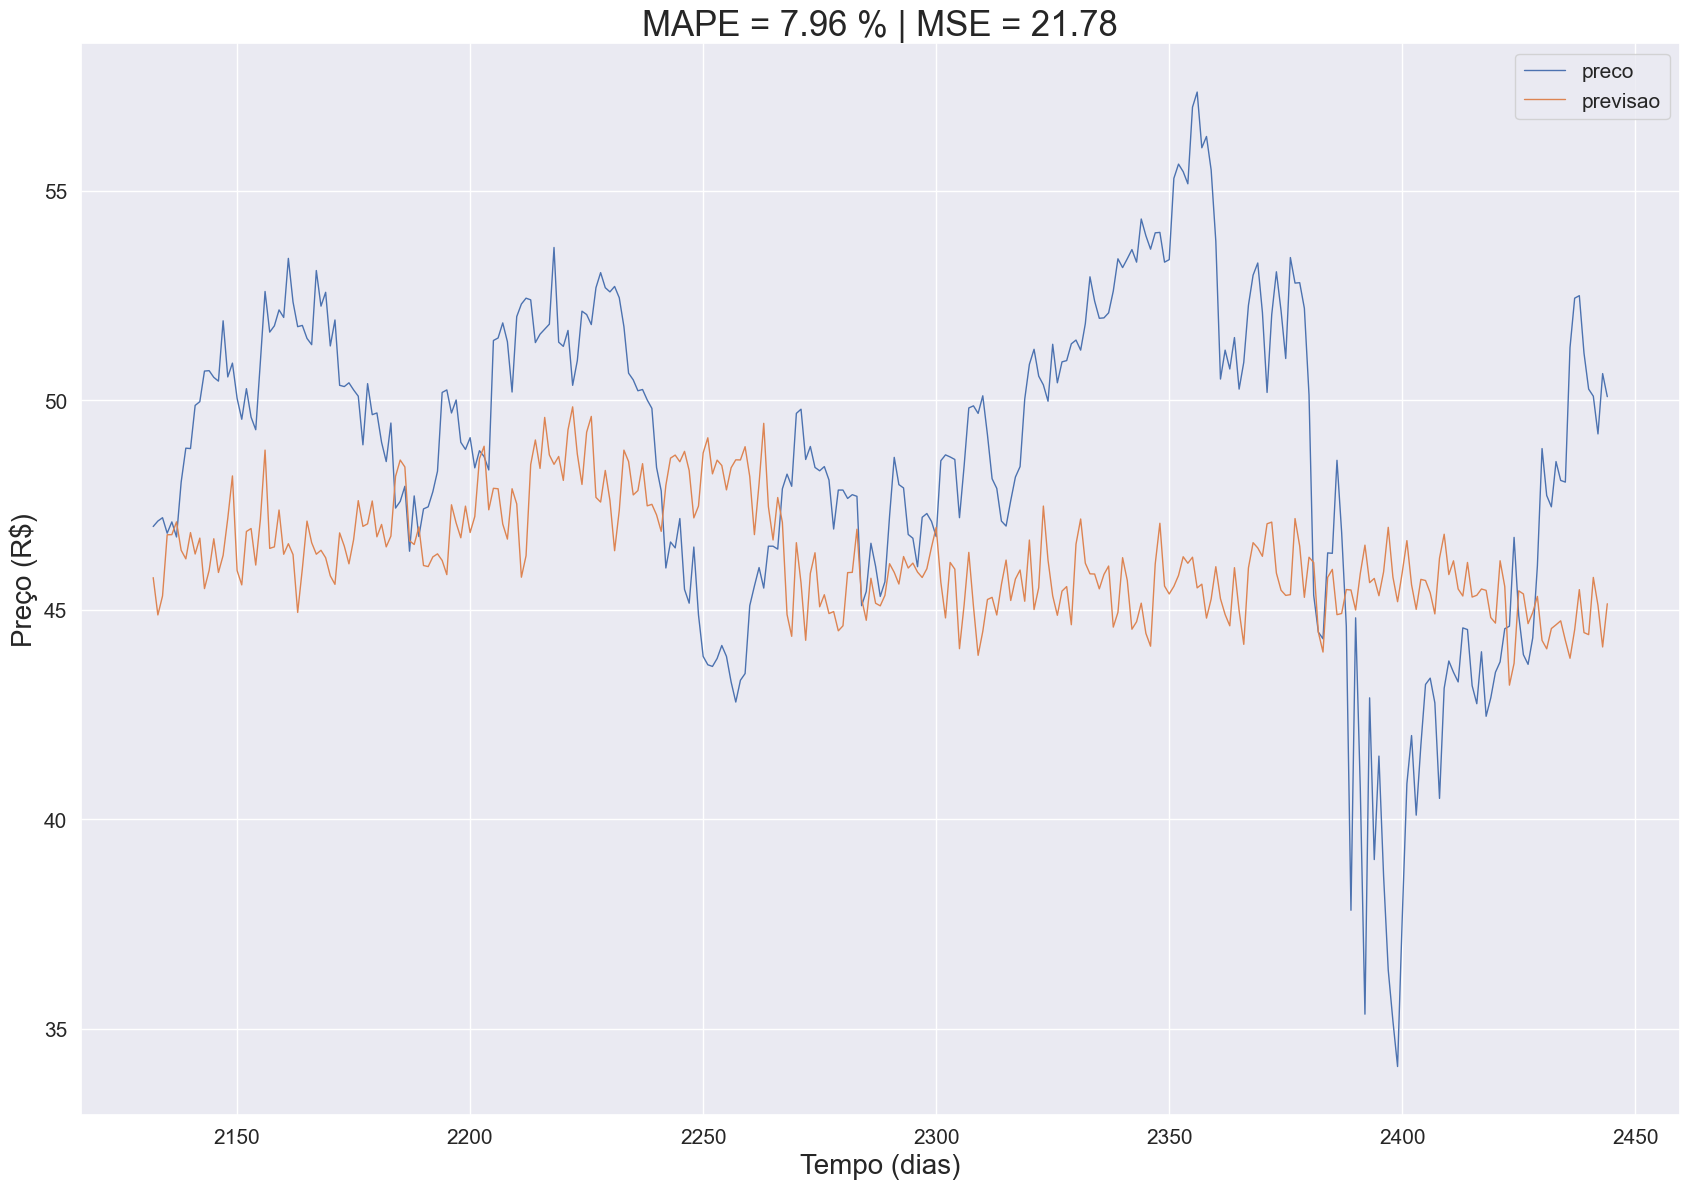

In [107]:
show_result_model(df_test=df_test,
                  y_forecast=y_ar_forecast,
                  model_name='ar_model',
                  dict_results=dict_results)

#### zoom

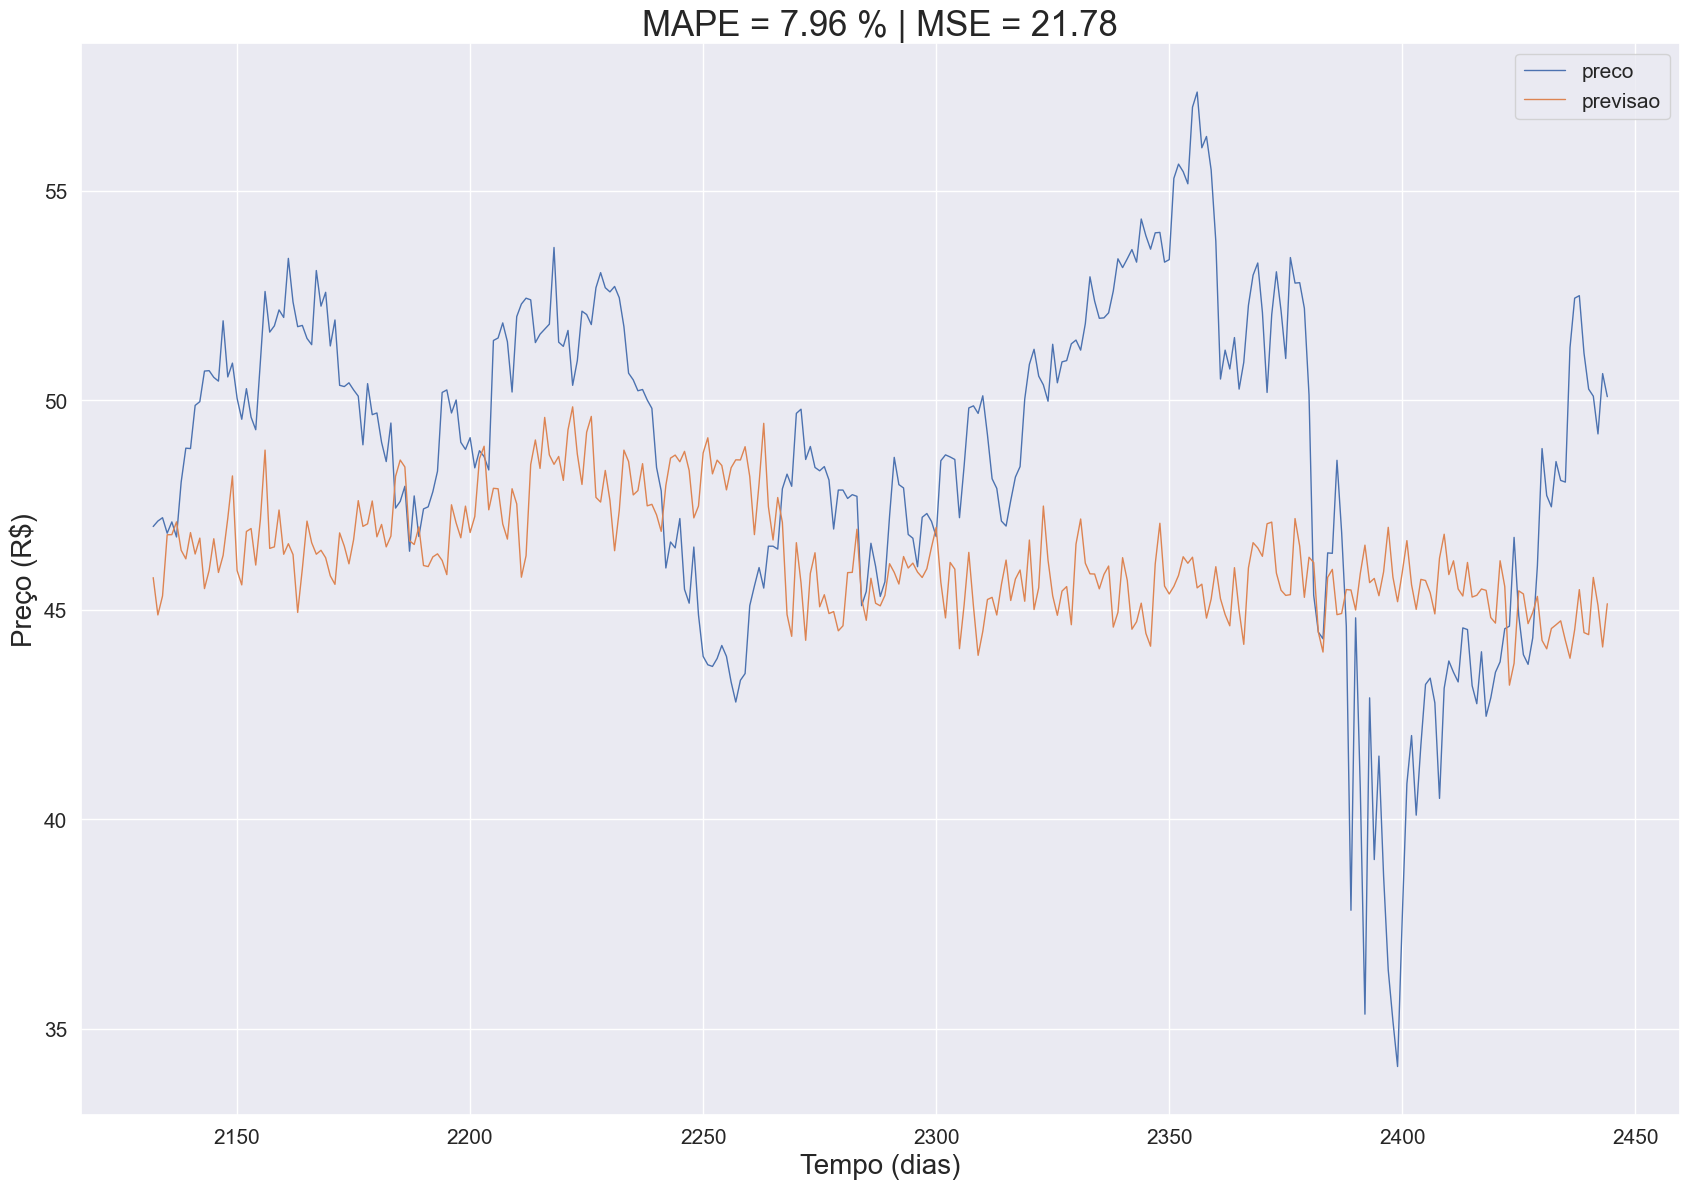

In [109]:
show_result_model(df_test=df_test,
                  y_forecast=y_ar_forecast,
                  model_name='ar_model',
                  dict_results=dict_results)

<br/>

#### **ARIMA**

In [111]:
%%time

list_order_arima = search_best_params_arima_model(df_train=df_train, pdq=list_pdq)
print(list_order_arima)

best ARIMA: (0, 0, 0) | AIC:99999
[(0, 0, 0), 99999]
CPU times: user 192 µs, sys: 63 µs, total: 255 µs
Wall time: 212 µs


In [112]:
%%time

autoarima_model = pm.auto_arima(df_train,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                information_criterion='aic',
                                start_p=2,
                                start_d=1,
                                start_q=2,
                                lags=313,
                                seasonal=False,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5189.626, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5202.401, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5202.744, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5202.427, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5200.421, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5191.786, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5192.782, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5191.420, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5191.381, Time=2.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5195.793, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5189.941, Time=1.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5194.800, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5193.582, Time=1.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5187.657, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [113]:
print(autoarima_model.order)
print(autoarima_model.aic())

(2, 1, 2)
5187.656934970851


In [114]:
# fit
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [115]:
# forecast
y_forecast = autoarima_model_fit.predict(n_periods=len(df_test[:313]))
len(y_forecast)

313

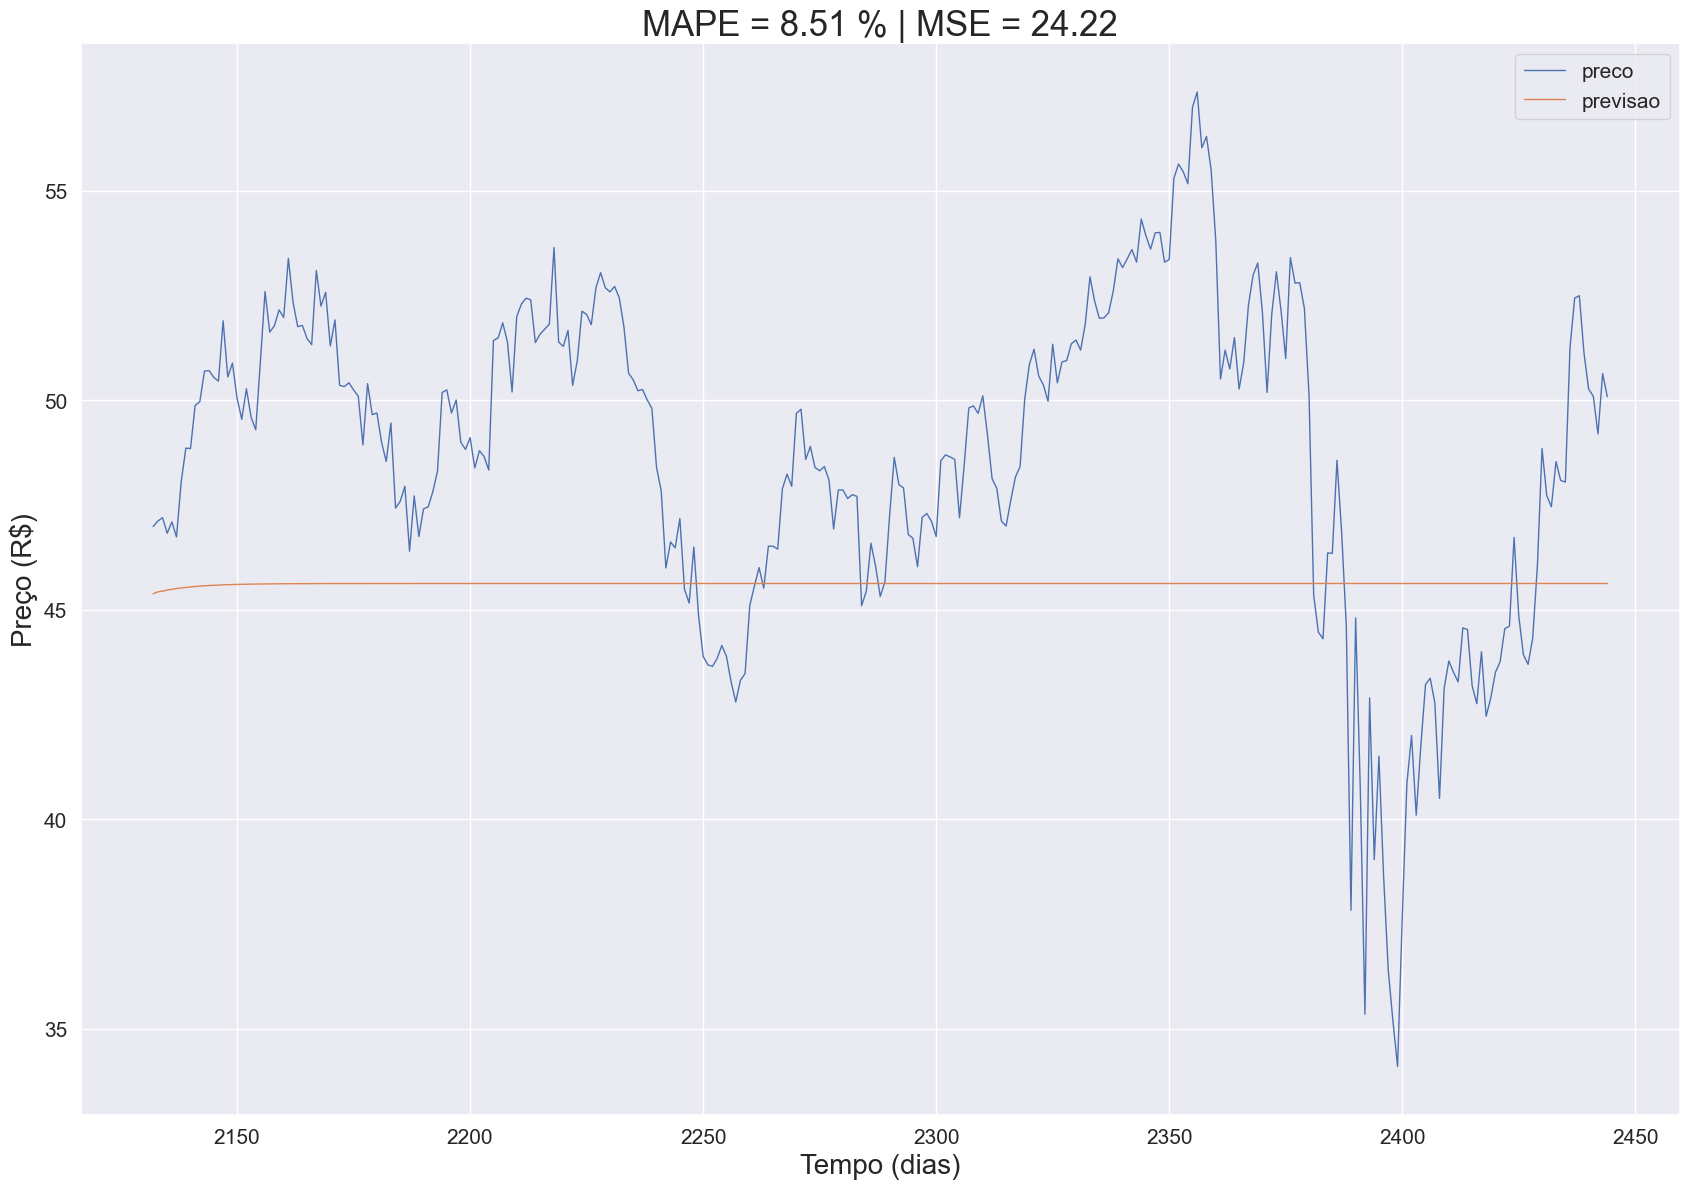

In [116]:
show_result_model(df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model',
                  dict_results=dict_results)

#### Zoom

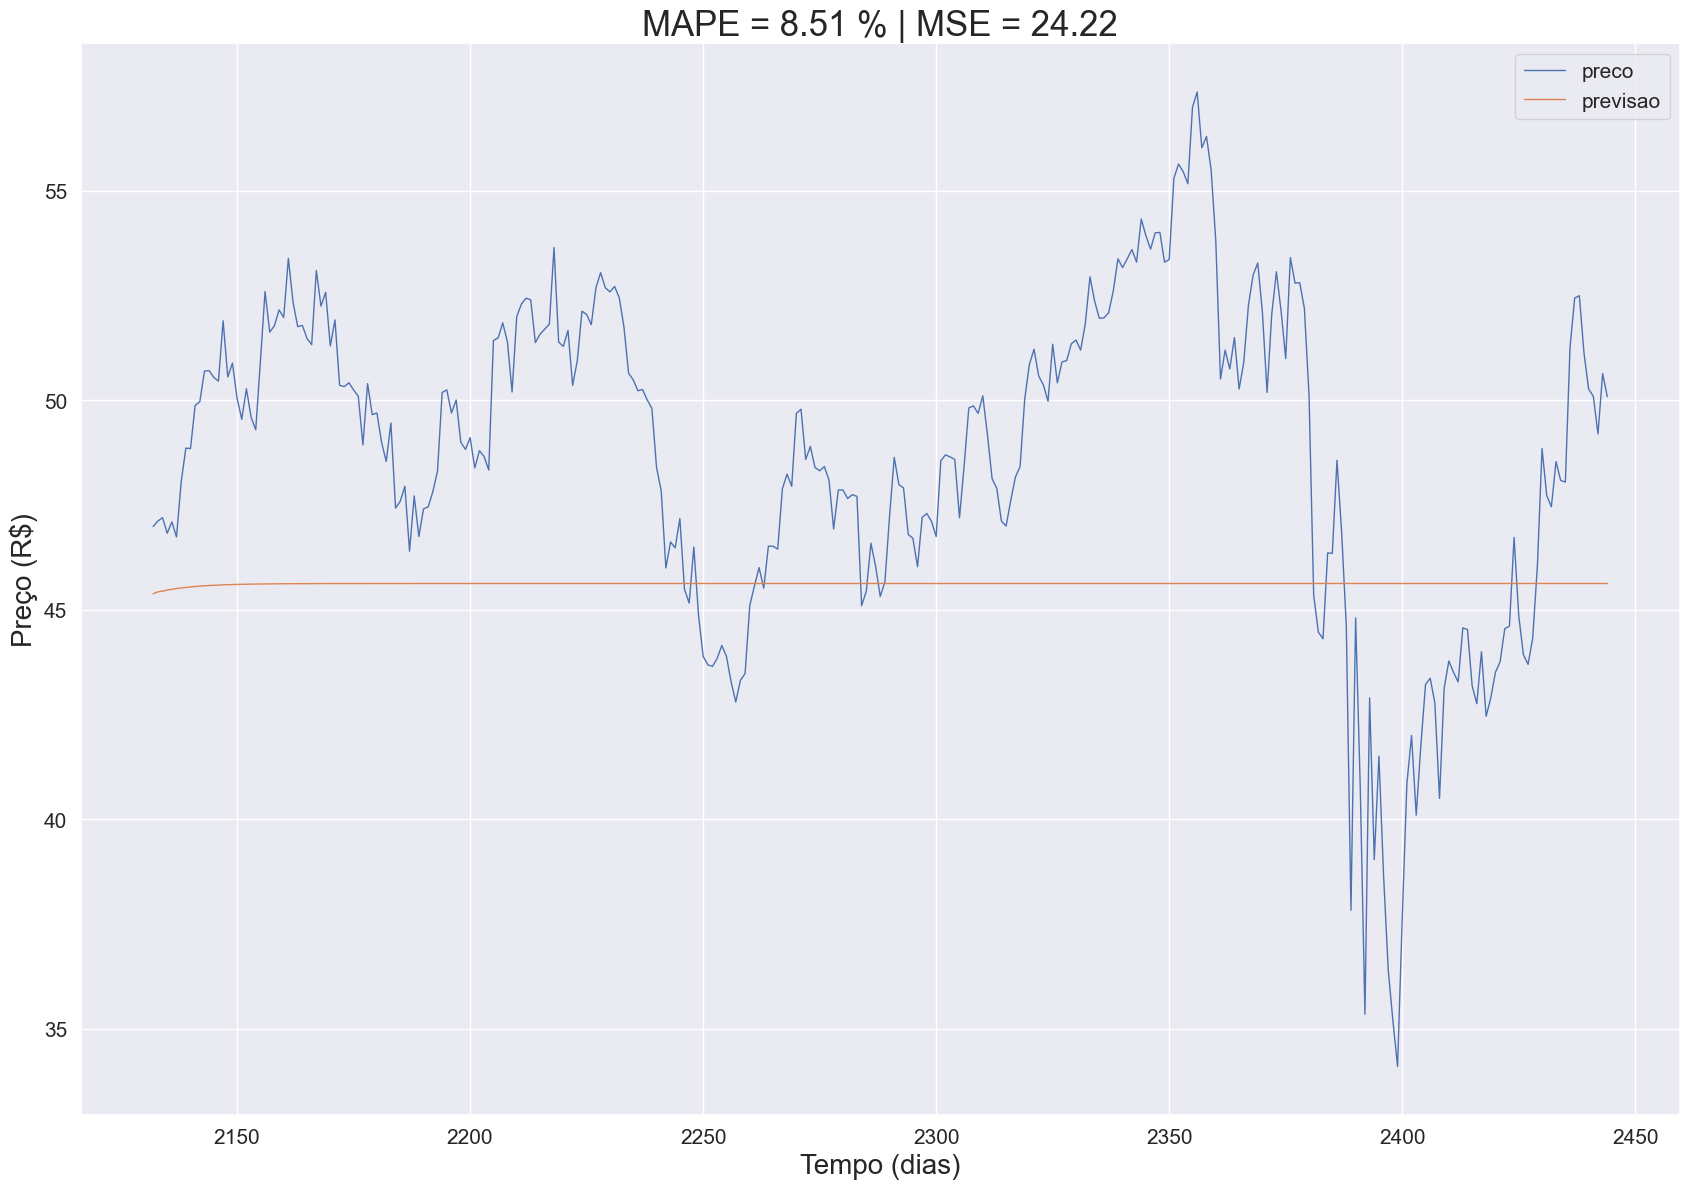

In [119]:
show_result_model(df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model',
                  dict_results=dict_results)

<br/>

#### **SARIMA**

In [120]:
%%time

list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train, trend='t', pdq=(2, 1, 2))
print(list_order_seasonal_aic)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21483D+00    |proj g|=  2.69588D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     43      2     0     0   8.074D-03   1.215D+00
  F =   1.2147144000632439     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (0, 0, 0, 12) | AIC = 5191.542201869672
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21438D+00    |proj g|=  2.94332D+02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     16      1     0     0   9.500D-03   1.214D+00
  F =   1.2142515441490256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (0, 0, 1, 12) | AIC = 5191.568584251445


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21378D+00    |proj g|=  3.21228D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     22      1     0     0   1.318D-02   1.214D+00
  F =   1.2136546195329667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (0, 0, 2, 12) | AIC = 5191.02329768857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56589D+00    |proj g|=  4.32040D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     46      2     0     0   3.743D+05   1.561D+00
  F =   1.5612215958379552     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (0, 1, 0, 12) | AIC = 6669.048884653041



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49609D+00    |proj g|=  8.70151D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     46      2     0     0   7.540D+06   1.408D+00
  F =   1.4081728189199594     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (0, 1, 1, 12) | AIC = 6018.4488998747065


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36029D+00    |proj g|=  6.06637D+07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     46      2     0     0   5.258D+07   1.809D+00
  F =   1.8091974299028450     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (0, 1, 2, 12) | AIC = 7730.417841105731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08488D+00    |proj g|=  3.86207D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     17      1     0     0   2.750D-01   2.085D+00
  F =   2.0848759747998193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (0, 2, 0, 12) | AIC = 8901.91115654643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92672D+00    |proj g|=  9.45914D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     43      2     0     0   3.113D+00   1.926D+00
  F =   1.9257349698008583     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (0, 2, 1, 12) | AIC = 8225.33391123086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86555D+00    |proj g|=  5.06532D+04


 This problem is unconstrained.



At iterate    5    f=  1.81089D+00    |proj g|=  1.71211D+01

At iterate   10    f=  1.80969D+00    |proj g|=  2.55081D+02

At iterate   15    f=  1.79989D+00    |proj g|=  1.96343D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     36      1     0     0   1.974D+03   1.795D+00
  F =   1.7949670273702965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (0, 2, 2, 12) | AIC = 7669.739404706944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21432D+00    |proj g|=  2.67240D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     43      2     0     0   8.000D-03   1.214D+00
  F =   1.2142192168977597     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (1, 0, 0, 12) | AIC = 5191.430740852047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21529D+00    |proj g|=  9.51053D+02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     16      1     0     0   2.848D-02   1.214D+00
  F =   1.2143618069452442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (1, 0, 1, 12) | AIC = 5194.038744814521


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21430D+00    |proj g|=  6.20437D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     13      1     0     0   1.856D-02   1.214D+00
  F =   1.2138371926752165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (1, 0, 2, 12) | AIC = 5193.801789567123
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     46      2     0     0   3.738D+05   1.434D+00
  F =   1.4335968248919964     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (1, 1, 0, 12) | AIC = 6126.856861339473
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46630D+00    |proj g|=  6.87278D+06


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     46      2     0     0   5.955D+06   1.396D+00
  F =   1.3962272916863550     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (1, 1, 1, 12) | AIC = 5969.513171750617


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55953D+00    |proj g|=  1.43134D+07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     46      2     0     0   1.241D+07   1.449D+00
  F =   1.4486455283030124     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (1, 1, 2, 12) | AIC = 6195.024532684045
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87054D+00    |proj g|=  4.59069D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     11      1     0     0   2.187D-01   1.870D+00
  F =   1.8704901872378350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (1, 2, 0, 12) | AIC = 7989.770158382128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75336D+00    |proj g|=  4.23899D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     39      2     0     0   3.451D-01   1.749D+00
  F =   1.7487250822841123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (1, 2, 1, 12) | AIC = 7472.563750859455


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90906D+00    |proj g|=  5.50383D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     43      2     0     0   3.706D+00   1.908D+00
  F =   1.9084404570242748     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (1, 2, 2, 12) | AIC = 8155.590108751508
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21365D+00    |proj g|=  2.62160D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     17      1     0     0   7.851D-03   1.214D+00
  F =   1.2135733165509757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (2, 0, 0, 12) | AIC = 5190.67662177336
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21477D+00    |proj g|=  8.47446D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     15      1     0     0   2.537D-02   1.214D+00
  F =   1.2140210608396207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (2, 0, 1, 12) | AIC = 5194.585803420143


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21423D+00    |proj g|=  5.97814D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     18      1     0     0   1.788D-02   1.214D+00
  F =   1.2137991882729762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (2, 0, 2, 12) | AIC = 5195.6397387959705


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39939D+00    |proj g|=  4.29858D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     46      2     0     0   3.725D+05   1.395D+00
  F =   1.3949069675171486     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (2, 1, 0, 12) | AIC = 5963.8833094931215
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44378D+00    |proj g|=  5.52793D+06


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     46      2     0     0   4.790D+06   1.387D+00
  F =   1.3872681522269941     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (2, 1, 1, 12) | AIC = 5933.3114010959025


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57757D+00    |proj g|=  1.54559D+07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     46      2     0     0   1.340D+07   1.458D+00
  F =   1.4582230616039611     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (2, 1, 2, 12) | AIC = 6237.86313467929


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80505D+00    |proj g|=  4.82354D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     20      1     0     0   2.858D-01   1.805D+00
  F =   1.8049894811305469     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (2, 2, 0, 12) | AIC = 7712.475147540652


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74831D+00    |proj g|=  8.21896D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     21      1     0     0   6.139D-01   1.747D+00
  F =   1.7473955286538885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (2, 2, 1, 12) | AIC = 7468.894534180181


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82453D+00    |proj g|=  1.12003D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     18      1     0     0   4.385D+00   1.823D+00
  F =   1.8232464980761920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (2, 2, 2, 12) | AIC = 7794.323067796882


Best SARIMA: (2, 1, 2)x(2, 2, 2, 12)12 | AIC:5190.67662177336
[(2, 0, 0, 12), 5190.67662177336]
CPU times: user 9min 30s, sys: 2min 38s, total: 12min 8s
Wall time: 3min 22s


In [121]:
list_order_seasonal_aic

[(2, 0, 0, 12), 5190.67662177336]

In [122]:
sarima_model = SARIMAX(df_train,
                       order=(2, 1, 2),
                       seasonal_order=list_order_seasonal_aic[0],
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [123]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19948D+00    |proj g|=  2.42592D-02


 This problem is unconstrained.



At iterate    5    f=  1.19945D+00    |proj g|=  4.39855D-04

At iterate   10    f=  1.19944D+00    |proj g|=  2.59867D-03

At iterate   15    f=  1.19943D+00    |proj g|=  8.45670D-05

At iterate   20    f=  1.19943D+00    |proj g|=  5.13645D-04

At iterate   25    f=  1.19943D+00    |proj g|=  2.07305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     29      1     0     0   6.350D-05   1.199D+00
  F =   1.1994297064625663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [125]:
# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1]).to_numpy()
len(y_forecast_sarima)

313

313

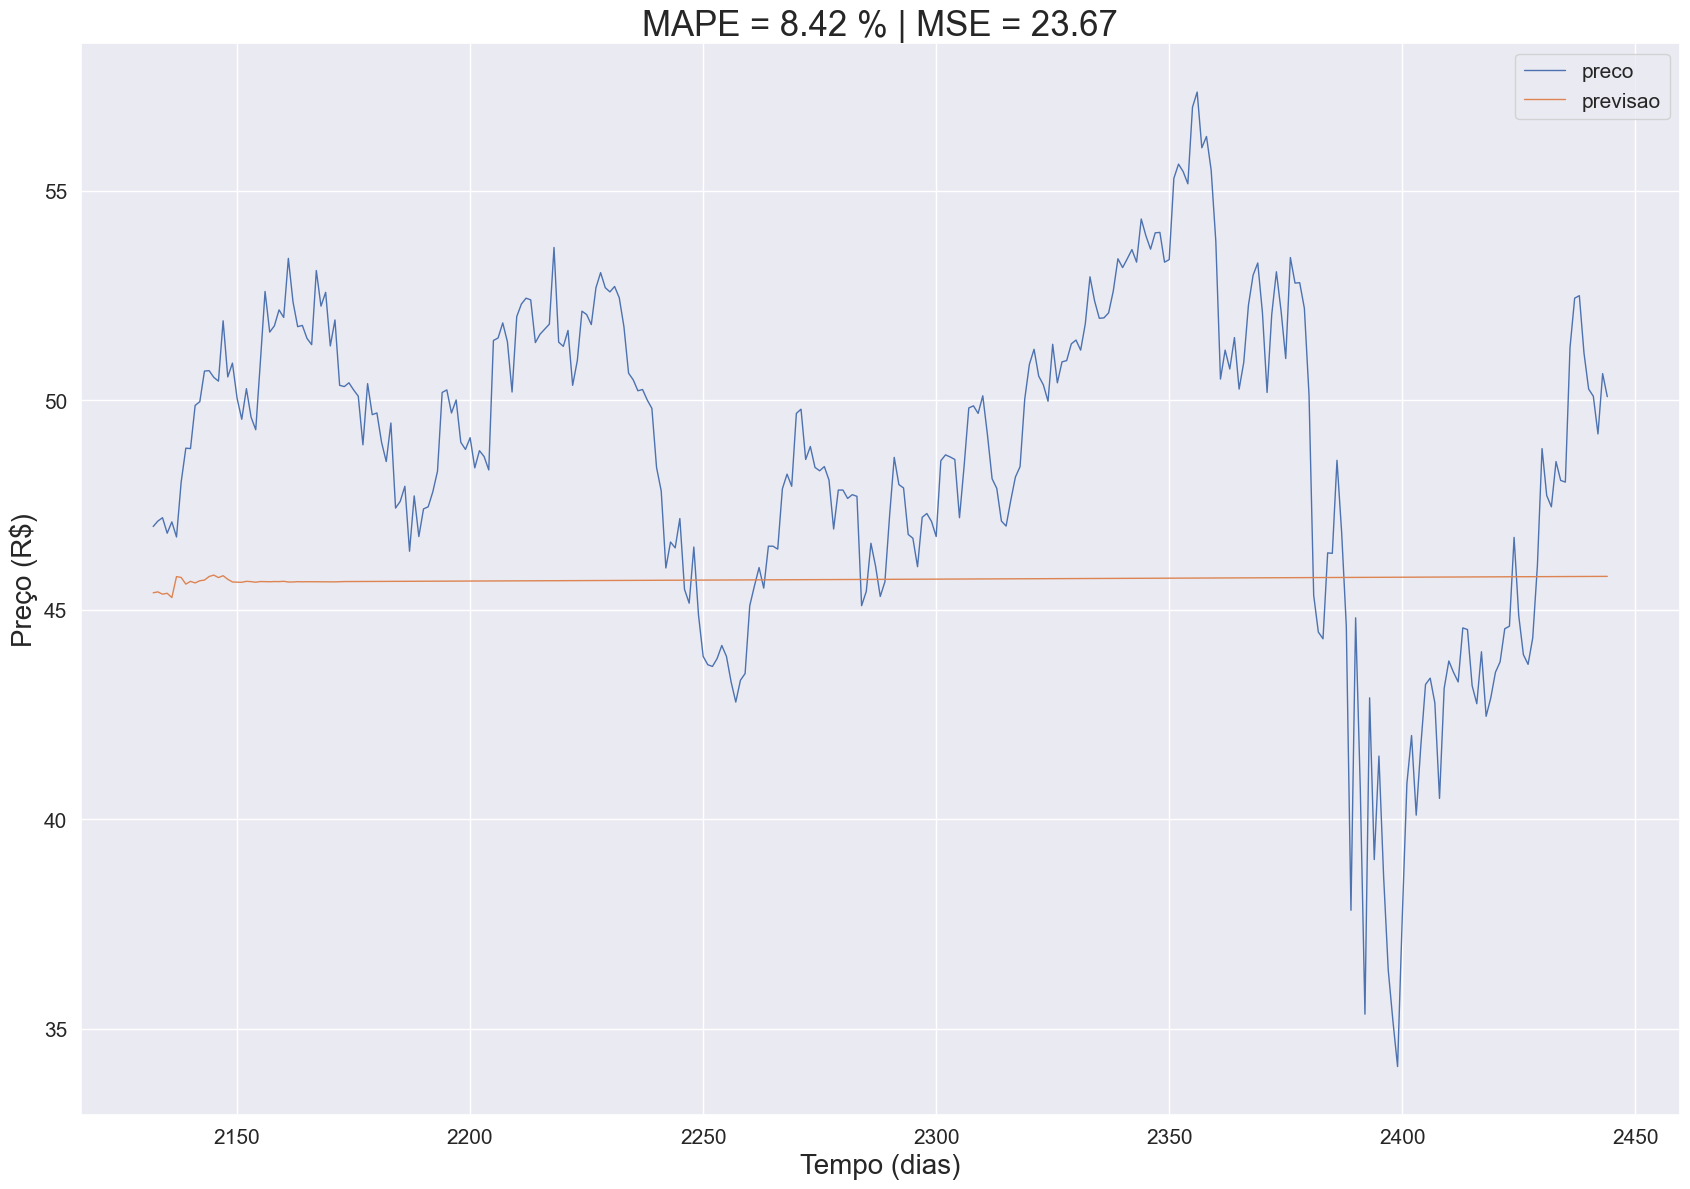

In [126]:
show_result_model(df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model',
                  dict_results=dict_results)

---

## **Results**

In [127]:
dict_results

{'ar_model': [7.955813872007056, 21.78036501064046],
 'arima_model': [8.514615050083238, 24.220703031723577],
 'sarima_model': [8.423669799076144, 23.66724110854228]}

---
